In [283]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

In [284]:
n_samples = 2000
X , y = make_circles(n_samples, noise=0.03,  random_state=43)

In [285]:
X.shape , y.shape

((2000, 2), (2000,))

In [286]:
import pandas as pd

df = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"Y":y})
df.head(5)

,X1,X2,Y
0,-0.795223,0.063624,1
1,-0.276033,0.739022,1
2,-0.330843,0.920113,0
3,-0.768350,-0.226800,1
4,-0.180776,-0.821417,1


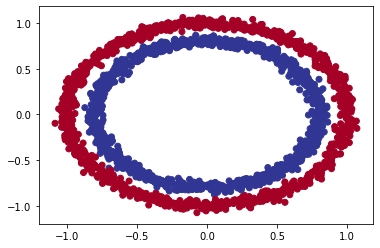

In [287]:
plt.scatter(X[:, 0], X[:, 1], c=y,  cmap=plt.cm.RdYlBu)

In [288]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [289]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32).unsqueeze(dim = 1)
split_percentage = int(0.8*len(X))
X_train , y_train = X[:split_percentage], y[:split_percentage]
X_test,y_test = X[split_percentage:], y[split_percentage:]

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print(y_train.shape)

torch.Size([1600, 1])


In [290]:
class circle_model_v0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2,out_features=10)
        self.linear_layer2 = nn.Linear(in_features=10,out_features=1)
        
    def  forward(self,x : torch.tensor) -> torch.Tensor:
        return self.linear_layer2(self.linear_layer1(x))
    
def plotting(x,y,predictions = None):
    plt.scatter(x,y,c = "r")
    if predictions is not None:
        plt.scatter(x,predictions,c = "b")



In [291]:
model = circle_model_v0()
model.to(device)

circle_model_v0(
  (linear_layer1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=1, bias=True)
)

In [292]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998],
         [ 0.5451,  0.1045],
         [-0.3301,  0.1802]], requires_grad=True),
 Parameter containing:
 tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
          0.0667, -0.6984], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
           0.0346, -0.0997]], requires_grad=True),
 Parameter containing:
 tensor([0.0850], requires_grad=True)]

In [293]:
model.state_dict()

OrderedDict([('linear_layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('linear_layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('linear_layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997]])),
             ('linear_layer2.bias', tensor([0.0850]))])

In [294]:
loss = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params = model.parameters(),lr = 0.01)

In [295]:
def accuracy_fn(y_pred, y_true):
   correct = torch.eq(y_true,y_pred).sum().item()
   acc = (correct/len(y_pred)) * 100
   return acc

In [296]:
torch.manual_seed(42)
epochs  = 100
epoch_set = []
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
    model.train()
    y_preds = model(X_train)
  
    y_preds1 = torch.round(torch.sigmoid(y_preds))
    loss1 = loss(y_preds,y_train)
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    model.eval()
    epoch_set.append(epoch)
    train_loss.append(loss1.item())
    train_acc = accuracy_fn(y_preds1,y_train)
    train_accuracy.append(train_acc)
    with torch.inference_mode():
        y_logits_test = model(X_test)
        y_preds2 = torch.round(torch.sigmoid(y_logits_test))
        loss2 = loss(y_logits_test,y_test)
        test_loss.append(loss2.item())
        test_acc = accuracy_fn(y_preds2,y_test)
        test_accuracy.append(test_acc)
    print("Epoch: {}, Train Loss: {}, Train acc: {} , Test Loss: {} , Test acc: {}".format(epoch,loss1.item(),train_acc,loss2.item(),test_acc))
    
    
    
    

Epoch: 0, Train Loss: 0.7039431929588318, Train acc: 48.4375 , Test Loss: 0.689139187335968 , Test acc: 53.0
Epoch: 1, Train Loss: 0.7010738849639893, Train acc: 48.375 , Test Loss: 0.6889064311981201 , Test acc: 53.5
Epoch: 2, Train Loss: 0.6989859938621521, Train acc: 49.1875 , Test Loss: 0.6891758441925049 , Test acc: 54.25
Epoch: 3, Train Loss: 0.6974489092826843, Train acc: 49.5625 , Test Loss: 0.6897106766700745 , Test acc: 55.00000000000001
Epoch: 4, Train Loss: 0.696225643157959, Train acc: 49.9375 , Test Loss: 0.6903913021087646 , Test acc: 56.49999999999999
Epoch: 5, Train Loss: 0.6952032446861267, Train acc: 50.81250000000001 , Test Loss: 0.6911877393722534 , Test acc: 56.75
Epoch: 6, Train Loss: 0.6943615674972534, Train acc: 52.75 , Test Loss: 0.6920989751815796 , Test acc: 50.74999999999999
Epoch: 7, Train Loss: 0.6937066912651062, Train acc: 49.8125 , Test Loss: 0.6931272745132446 , Test acc: 50.74999999999999
Epoch: 8, Train Loss: 0.6932459473609924, Train acc: 49.8125 

In [297]:
y_preds_test = torch.sigmoid(y_logits_test)
y_preds_test = torch.round(y_preds_test)
print(y_preds_test,y_logits_test)
accuracy_fn(y_preds_test, y_test)

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
      

46.0

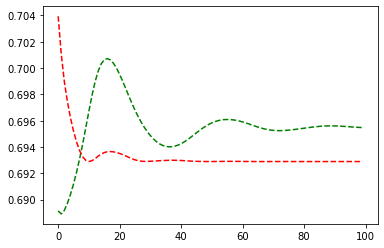

In [298]:
def plot_epoch_loss(epoch,loss,color):
    plt.plot(epoch,loss,color)
plot_epoch_loss(epoch_set,test_loss,color = "g--")
plot_epoch_loss(epoch_set,train_loss,color = "r--")

In [299]:
model.eval()
with torch.inference_mode():
    y_p = model(X_test)


In [300]:
torch.save(model.state_dict(),"models/circle_model_v0.pth")

In [301]:
# torch.cuda.manual_seed(42) for gpu

BCELOSS with logits come with sigmoid we dont want to put in after nn.linear_layr

but bceloss we want to use loss(torch.sigmoid(y_logits))

In [302]:
import requests
from pathlib import Path

if Path("helper.py").is_file():
    print("file existed")
else:
    print("Downloading from github repo  --  ")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper.py", "wb") as f:
        f.write(request.content)

file existed


torch.Size([1, 1600, 2]) torch.Size([1600])


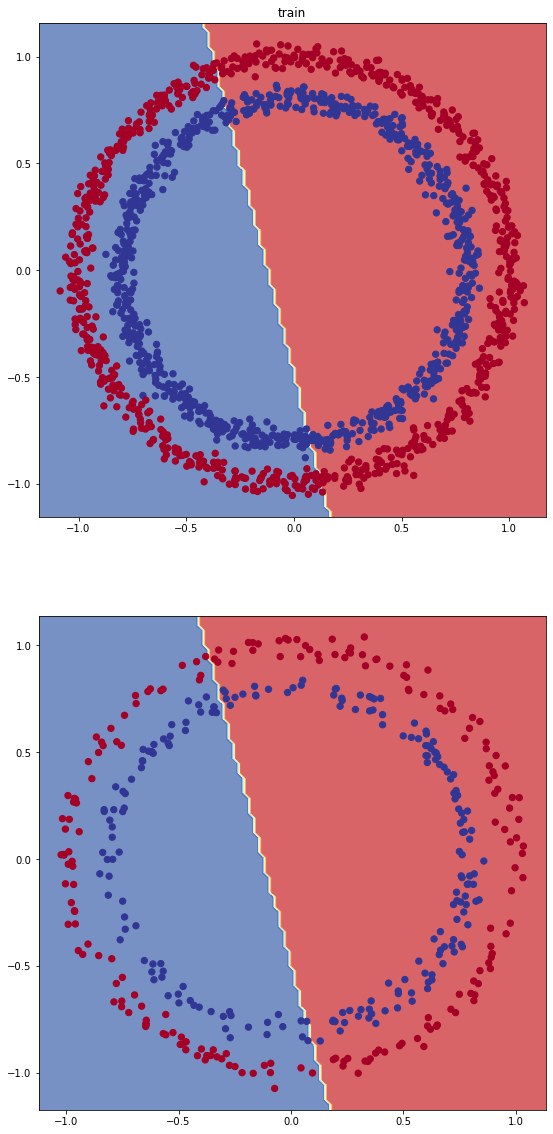

In [303]:
from helper import plot_decision_boundary,plot_predictions
print(X_train.unsqueeze(dim = 0).shape , y_train.squeeze(dim = 1).shape)
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("train")
plot_decision_boundary(model,X=X_train,y = y_train.squeeze(dim = 1))
plt.subplot(2,2,3)
plot_decision_boundary(model,X = X_test,y = y_test.squeeze(dim = 1))
 


Improve model's performance  --

1. Add more layers  - give chance to model to learn pattern
2. Add more hidden units  -  5 to 10 to 20
3. change activation function
4. change loss function
5. change optimizer function
6. Fit for longer i mean epochs
7. change learning rate


we use torch.utils.tensorboard

WE can use Sequential also 

model1 = nn.Sequential(

    nn.Linear(3,128),

    nn.ReLU(),

    nn.Linear(128,64),

    nn.ReLU(),

    nn.Linear(64,2)
    
)

In [304]:
class circle_model_v1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2,out_features=10)
        self.linear_layer2 = nn.Linear(in_features=10,out_features=10)
        self.linear_layer3 = nn.Linear(in_features=10,out_features=1)
        
    def  forward(self,x : torch.tensor) -> torch.Tensor:
        return self.linear_layer3(self.linear_layer2(self.linear_layer1(x)))

In [305]:
model_v1 = circle_model_v1()
model_v1.state_dict()

OrderedDict([('linear_layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('linear_layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('linear_layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2

In [306]:
loss_v1 = torch.nn.BCEWithLogitsLoss()
optimizer_v1 = torch.optim.SGD(model_v1.parameters(), lr=0.001)

In [307]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

epoch_set_v1 = []
train_loss_v1 = []
test_loss_v1 = []
train_accuracy_v1 = []
test_accuracy_v1 = []
for epoch in range(epochs):
    model_v1.train()
    y_preds_v1 = model_v1(X_train)
  
    y_preds1_v1 = torch.round(torch.sigmoid(y_preds_v1))
    loss1_v1 = loss(y_preds_v1,y_train)
    optimizer_v1.zero_grad()
    loss1_v1.backward()
    optimizer_v1.step()
    model_v1.eval()
    epoch_set_v1.append(epoch)
    train_loss_v1.append(loss1_v1.item())
    train_acc_v1 = accuracy_fn(y_preds1_v1,y_train)
    train_accuracy_v1.append(train_acc_v1)
    with torch.inference_mode():
        y_logits_test_v1 = model_v1(X_test)
        y_preds2_v1 = torch.round(torch.sigmoid(y_logits_test_v1))
        loss2_v1 = loss(y_logits_test_v1,y_test)
        test_loss_v1.append(loss2_v1.item())
        test_acc_v1 = accuracy_fn(y_preds2_v1,y_test)
        test_accuracy_v1.append(test_acc_v1)
    print("Epoch: {}, Train Loss: {}, Train acc: {} , Test Loss: {} , Test acc: {}".format(epoch,loss1_v1.item(),train_acc_v1,loss2_v1.item(),test_acc_v1))
    
    
    
    

Epoch: 0, Train Loss: 0.6930564045906067, Train acc: 52.1875 , Test Loss: 0.6963729858398438 , Test acc: 45.5
Epoch: 1, Train Loss: 0.6930563449859619, Train acc: 52.1875 , Test Loss: 0.6963727474212646 , Test acc: 45.5
Epoch: 2, Train Loss: 0.6930561661720276, Train acc: 52.1875 , Test Loss: 0.6963725090026855 , Test acc: 45.5
Epoch: 3, Train Loss: 0.693056046962738, Train acc: 52.1875 , Test Loss: 0.6963725090026855 , Test acc: 45.5
Epoch: 4, Train Loss: 0.6930558681488037, Train acc: 52.1875 , Test Loss: 0.6963722705841064 , Test acc: 45.5
Epoch: 5, Train Loss: 0.6930557489395142, Train acc: 52.1875 , Test Loss: 0.6963722109794617 , Test acc: 45.5
Epoch: 6, Train Loss: 0.6930555701255798, Train acc: 52.1875 , Test Loss: 0.6963719725608826 , Test acc: 45.5
Epoch: 7, Train Loss: 0.6930553317070007, Train acc: 52.1875 , Test Loss: 0.6963719129562378 , Test acc: 45.5
Epoch: 8, Train Loss: 0.693055272102356, Train acc: 52.1875 , Test Loss: 0.6963716745376587 , Test acc: 45.5
Epoch: 9, Tr

torch.Size([1, 1600, 2]) torch.Size([1600])


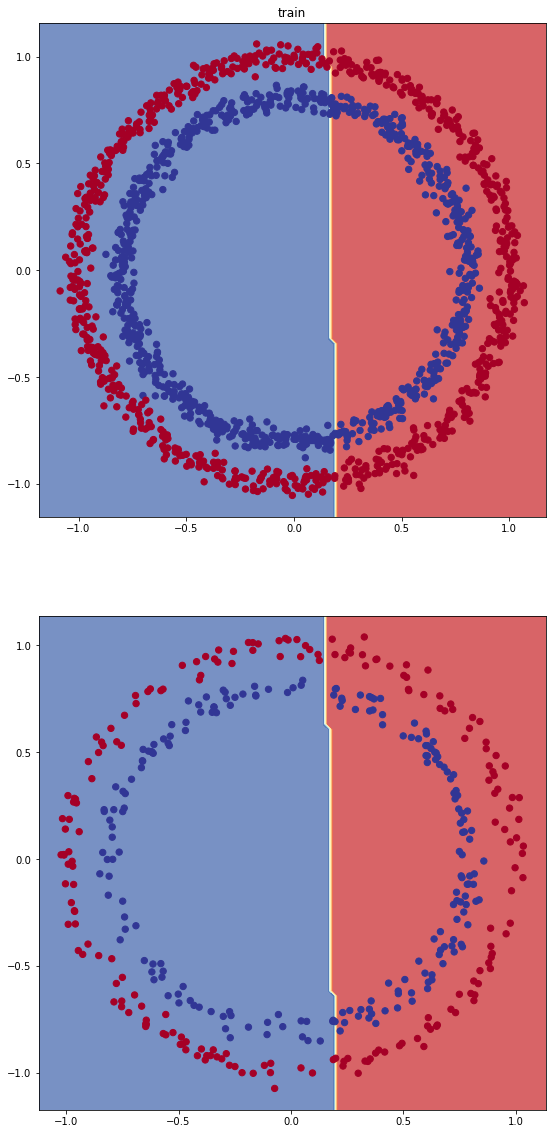

In [308]:
from helper import plot_decision_boundary,plot_predictions
print(X_train.unsqueeze(dim = 0).shape , y_train.squeeze(dim = 1).shape)
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("train")
plot_decision_boundary(model_v1,X=X_train,y = y_train.squeeze(dim = 1))
plt.subplot(2,2,3)
plot_decision_boundary(model_v1,X = X_test,y = y_test.squeeze(dim = 1))
 
